Part 1 QR

In [242]:
#Problem 1
import numpy as np
import pandas as pd
from scipy import linalg as la
import cmath
import math
def QR(A):
    (m,n) = A.shape
    
    Q=np.copy(A)
    
    R=np.zeros((n,n))
    
    for i in range (n):
        R[i,i]=la.norm(Q[:,i])
        Q[:,i]=Q[:,i]/R[i,i]
        for j in range (i+1,n):
            R[i,j]=np.dot(np.transpose(Q[:,j]),Q[:,i])
            Q[:,j]=Q[:,j]-R[i,j]*Q[:,i]
    
    return Q,R

In [159]:
A=np.random.random((6,4))
Q,R=QR(A)
print(A.shape,Q.shape,R.shape)

(6, 4) (6, 4) (4, 4)


In [160]:
Q1,R1=la.qr(A,mode="economic")
print(A.shape,Q1.shape,R1.shape)

(6, 4) (6, 4) (4, 4)


In [161]:
np.allclose(np.triu(R),R)

True

In [162]:
np.allclose(Q.T@Q, np.identity(4))

True

In [163]:
np.allclose(Q@R,A)

True

In [164]:
#Problem 2
def getDet(A):
    m,n = A.shape
    if m!=n:
        print("A is not a squre.")
        return
    
    Q1, R1 = QR(A)
    det = 1
    for i in range(n):
        det *= R1[i,i]
    return det

In [165]:
B = np.random.random((5,5))
true_det = la.det(B)
my_det = getDet(B)
print("Error: ", true_det - my_det)

Error:  -2.7755575615628914e-17


In [166]:
#Problem 3
def solveLinearSystem(A, b):
    #A is a n*n linear matrix, invertible b is n*1
    if abs(la.det(A))<1e-6:
        print("A is not invertible")
        return
    Q1, R1 = QR(A)
    y = np.dot(np.transpose(Q1), b)
    m, n = A.shape
    x = np.empty(n)
    for i in range(n-1, -1, -1):
        x[i] = y[i] / R1[i,i]
        #update y
        for j in range(n):
            y[j] = y[j] - R1[j,i]*x[i]
        
    return x

In [167]:
A2 = np.random.random((5,5))
#add diagonals to make it invertible
A2 = A2 + 100*np.eye(5)
b2 = np.array([1,2,3,4,5])
print(np.dot(A2, solveLinearSystem(A2, b2)))


[1. 2. 3. 4. 5.]


In [168]:
#Problem 4
def householder(A):
    #A should be a matrix of m*n and has rank n
    sign = lambda x : 1 if x>= 0 else -1
    
    m, n = A.shape
    R = np.copy(A)
    Q = np.eye(m)
    for k in range(n):
        u = np.copy(R[k:, k])
        u[0] = u[0] + sign(u[0])*la.norm(u)
        u = u / la.norm(u)
        R[k:, k:] = R[k:, k:] - 2 * np.outer(u, np.matmul(np.transpose(u), R[k:, k:]))
        Q[k:, :] = Q[k:, :] - 2 * np.outer(u, np.matmul(np.transpose(u), Q[k:, :]))
    return np.transpose(Q), R

In [169]:
A = np.random.random((5,3))
Q, R = la.qr(A)
print(A.shape, Q.shape, R.shape)

(5, 3) (5, 5) (5, 3)


In [170]:
my_Q, my_R = householder(A)
np.allclose(my_Q@my_R, A)

True

In [171]:
np.allclose(my_Q, Q)

True

In [172]:
np.allclose(my_R, R)

True

In [173]:
#Problem 5

def hess(A):
    sign = lambda x : 1 if x>= 0 else -1
    
    #A is an invertible n*n matrix
    m, n = A.shape
    H = np.copy(A)
    Q = np.eye(m)
    for k in range(n-2):
        u = np.copy(H[k+1:, k])
        u[0] += sign(u[0]) * la.norm(u)
        u = u / la.norm(u)
        
        H[k+1: ,k:] -= 2 * np.outer(u, np.matmul(u, H[k+1:, k:]))
        H[:, k+1:] = H[:, k+1:] - 2 * np.outer(np.dot(H[:, k+1:], u), u.T)
        Q[k+1:, :] -= 2 * np.outer(u, np.matmul(np.transpose(u),Q[k+1:, :]))

    return H, np.transpose(Q)

A5 = np.random.random((8,8))
#add diagonals to make it invertible
A5 += 5*np.eye(8)
H, Q = la.hessenberg(A5, calc_q = True)
my_H, my_Q = hess(A5)


In [174]:
np.allclose(my_H, H)

True

In [175]:
np.allclose(my_Q, Q)

True

Part 2 Least Sq and Eigenvalues

In [176]:
#Problem 1 
def leastsqbyQR(A, b):
    #A is a m*n matrix, b is n*1 vector
    Q, R = la.qr(A, mode = "economic")
    #the linear system then becomes R \hat{x} = Q.T b
    #print(R)
    
    y = np.dot(np.transpose(Q), b)
    m, n = A.shape
    x_hat = np.empty(n)
    for i in range(n-1, -1, -1):
        x_hat[i] = y[i] / R[i,i]
        #update y
        for j in range(n):
            y[j] = y[j] - R[j,i]*x_hat[i]
        
    return x_hat

In [177]:
Als = np.array([[-1,1], [0, 1], [1, 1], [2,1]])
bls = np.array([0 ,1 ,2,1])
leastsqbyQR(Als, bls)

array([0.4, 0.8])

In [178]:
#Problem 2

import matplotlib.pyplot as plt
def fitLine():
    data = np.load("housing.npy")
    years = data[:, 0]
    prices = data[:, 1]
    
    constants = np.ones(len(years))
    A = np.column_stack((years, constants))
    coeff = leastsqbyQR(A, prices)
    print("Slope: ", coeff[0], "Intercept: ", coeff[1])
    plt.plot(years, prices, "o", markersize = 4)
    plt.xlabel("Year")
    plt.ylabel("Price Index")
    plt.title("Regression Line of Price Index with Year")
    plt.plot(np.arange(18), coeff[0]*np.arange(18)+coeff[1])
    plt.show()
    
    
    

Slope:  3.3747660427807578 Intercept:  164.08096256684485


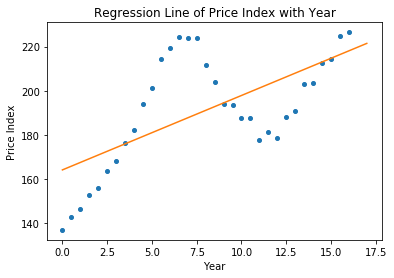

In [179]:
fitLine()

Is the calculated result the same from np.polyfut?  True


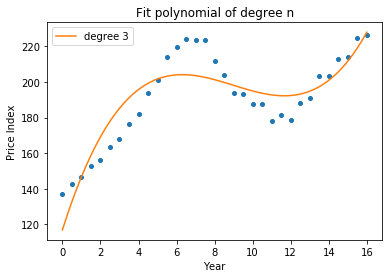

In [180]:
#Problem 3
def fit_degree_n(n, x_vec, b_vec):
    # a degree n polynomial should have the form [a_n, a_{n-1}, ..., a_1, a_0].T * [x^n, ,,,, x, 1]
    # create a vandermonde matrix 
    A = np.vander(x_vec, n+1)
    coeff = la.lstsq(A, b_vec)[0]
    
    #regression polynomial
    my_poly = np.poly1d(coeff)
    
    #plot true values
    plt.plot(x_vec, b_vec, "o", markersize = 4)
    plt.xlabel("Year")
    plt.ylabel("Price Index")
    plt.title("Fit polynomial of degree n")
    
    #plot estimated values
    x_start = x_vec.min()
    x_end = x_vec.max()
    my_label = "degree " +str(n)
    plt.plot(np.linspace(x_start, x_end, 100), my_poly(np.linspace(x_start, x_end, 100)), label = my_label)
    plt.legend()
    
    #check with polyfit
    pf = np.polyfit(x_vec, b_vec, n)
    print("Is the calculated result the same from np.polyfut? ", np.allclose(coeff, pf))
    
    plt.show()
    

data = np.load("housing.npy")
years = data[:, 0]
prices = data[:, 1]
#degree 3
fit_degree_n(3, years, prices)

    

Is the calculated result the same from np.polyfut?  True


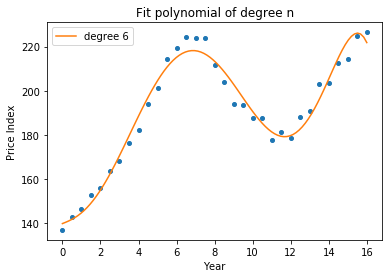

In [181]:
#degree 6
fit_degree_n(6, years, prices)

Is the calculated result the same from np.polyfut?  True


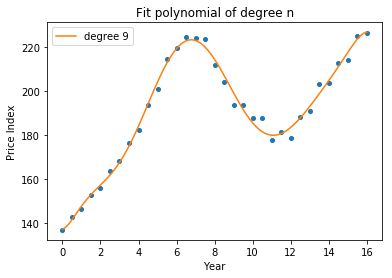

In [182]:
#degree 9
fit_degree_n(9, years, prices)

Is the calculated result the same from np.polyfut?  False


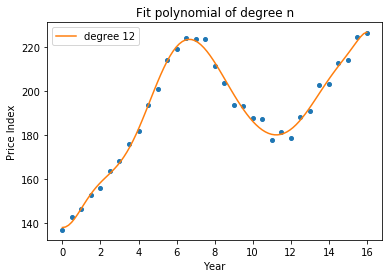

In [183]:
#degree 12
fit_degree_n(12, years, prices)

In [184]:
#Problem 4

Observe that the standard  equation of an ellipse is $$\frac{x^2}{a^2} + \frac{y^2}{b^2} = 1.$$ Let $m=\frac{1}{a^2}, n=\frac{1}{b^2}.$ It follows that $$mx^2 + ny^2 = 1.$$ This is a linear system in $m$ and $n$.
To plot the ellipse, we simply let $x=a\cos(\theta), y=b\sin(\theta)$.

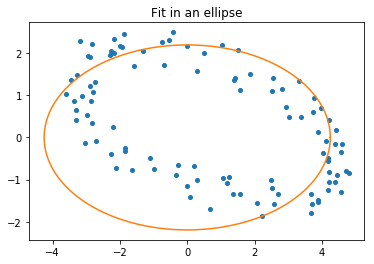

In [185]:
ellipse = np.load("ellipse.npy")
#print(ellipse)
x_vec = ellipse[:, 0]
y_vec = ellipse[:, 1]

def drawAnFittedellipse(x_vec, y_vec):
   #create a linear systems
    x2_vec = x_vec **2
    y2_vec = y_vec **2
    #RHS is a columns of ones
    b_vec = np.ones_like(x_vec)
    A = np.column_stack((x2_vec, y2_vec))
    coeff = la.lstsq(A, b_vec)[0]
    a = np.sqrt(1.0 / coeff[0])
    b = np.sqrt(1.0 / coeff[1])
    
    #plot
    plt.plot(x_vec, y_vec, "o", markersize = 4)
    theta_grid = np.linspace(0, 2*np.pi, 360)
    plt.plot(a*np.cos(theta_grid), b*(np.sin(theta_grid)))
    plt.title("Fit in an ellipse")
    plt.show()
drawAnFittedellipse(x_vec, y_vec)

In [186]:
#
def powerMethod(A, maxItr, tol):
    print("_______")
    m, n = A.shape
    x_0 = np.random.rand(n) + np.ones(n) # make it larger to avoid rounding error
    x_0 = x_0 / la.norm(x_0)
    currentItr = 0
    diff = 10
    
    while (currentItr<maxItr) or (diff > tol):
        x_prime = np.matmul(A, x_0)
        x_prime = x_prime / la.norm(x_prime)
        diff = la.norm(x_prime - x_0)
        x_0 = x_prime
        currentItr += 1
    eigval = np.dot(x_0, np.matmul(A, x_0))
    eigvec = x_0
    return eigval, eigvec

A = (np.random.random((10,10)) ) # make it larger to avoid rounding error
eigs, vec = la.eig(A)
loc = np.argmax(eigs)
lamb , x = eigs[loc], vec[loc]
my_lamb, my_x = powerMethod(A, 10000, 1e-16)
print("Does the eigvalue converge to true eigvalue?")
print(np.allclose(lamb, my_lamb))
print("Does the corresponding eigenvector satisfy Ax = lambda x?")
print(np.allclose(np.abs(my_lamb * my_x), np.abs(np.dot(A, my_x))))

    

_______
Does the eigvalue converge to true eigvalue?
True
Does the corresponding eigenvector satisfy Ax = lambda x?
True


In [187]:
#Problem 6 
def QRfindeig(A, N, tol):
    m, n = A.shape
    
    S, temp = la.hessenberg(A, calc_q = True)
    
   
    for k in range(N):
        Q, R = la.qr(S)
        S = np.matmul(R, Q)
    eigs = []
    
    i = 0
    while i < n:
        #if Si is 1*!
        if (i == (n-1)) or (abs(S[i+1,i])<tol):
            eigs.append(S[i,i])
        else:
            #Si is 2*2
            a = S[i,i]
            b = S[i,i+1]
            c = S[i+1, i]
            d = S[i+1, i+1]
            lamba_1 = 0.5 * (a + d + cmath.sqrt((a+d)^2 - 4*(a*d-b*c)))
            lamba_2 = 0.5 * (a + d - cmath.sqrt((a+d)^2 - 4*(a*d-b*c)))
            eigs.append(lambda_1)
            eigs.append(lambda_2)
            i += 1
        i += 1
    return eigs
            
#Construct a random symmetric matrix
A = np.random.random((5,5))
A = A + A.T
my_evals = QRfindeig(A, 1000, 1e-8)
my_evals.sort()
print("Calculation: ", my_evals)
evals, evecs = la.eig(A)
evals.sort()
print("True values: ", evals)
print("It can be seen that they are approximately the same.")

Calculation:  [-1.2783264809426085, -0.6156644002918699, 0.3652932720724131, 0.5788060278972718, 5.953125666338028]
True values:  [-1.27832648+0.j -0.6156644 +0.j  0.36529327+0.j  0.57880603+0.j
  5.95312567+0.j]
It can be seen that they are approximately the same.


Note that in the above code, we directly apply quadratic formula to calculate the eigenvalues of a 2*2 matrix.
We have the following:
$$(a-\lambda)(d-\lambda) - bc = 0 $$
$$\lambda^2 - (a+d)\lambda +(ad-bc) = 0$$
$$\lambda_1 = \frac{1}{2}[(a+d) + \sqrt{(a+d)^2 - 4(ad-bc)}] \text{ and } \lambda_2 = \frac{1}{2}[(a+d) - \sqrt{(a+d)^2 - 4(ad-bc)]}$$

Part 3 SVD

In [188]:
#Problem 1
def computeSVD(A,tol):
    
    lamda,V = la.eig(np.dot(A.conj().T,A))
    #get singular values
    sigma = np.sqrt(lamda)
    #sort 
    index = ((-1)*sigma).argsort()
    sigma = sigma[index]
    V = V[:,index]
    
    r = sum(i > tol for i in sigma)
    sigma1 = sigma[:r]
    V1 = V[:,:r]
    U1 = np.dot(A,V1)/sigma1
    return U1, sigma1, V1.conj().T

In [189]:
A = np.random.random((6,4))
U, s_vec, V = computeSVD(A, 1e-8)
print("Results:")
print(U)
print("------------------------")
print(s_vec)
print("------------------------")
print(V)
#print(U1.shape,s.shape,V1.shape)
#np.allclose(U.T@U,np.identity(5))
U2, s_vec2, V2 = la.svd(A)
print()
print("True SVD:")
print(U2)
print("------------------------")
print(s_vec2)
print("------------------------")
print(V2)
print("We know that orthornomal vectors can differentiate by a negative sign. We see that they yield the same result.")

Results:
[[ 0.45468781+0.j -0.29403009+0.j -0.79531096+0.j  0.19934071+0.j]
 [ 0.50909303+0.j  0.03533467+0.j  0.31690572+0.j -0.45567228+0.j]
 [ 0.28100431+0.j -0.45569852+0.j  0.11560944+0.j -0.35360577+0.j]
 [ 0.29745907+0.j -0.49224438+0.j  0.48921398+0.j  0.56824116+0.j]
 [ 0.32844296+0.j  0.53185604+0.j  0.11574894+0.j  0.51714864+0.j]
 [ 0.50868771+0.j  0.42362867+0.j -0.03094455+0.j -0.19299814+0.j]]
------------------------
[3.03010698+0.j 1.29155092+0.j 0.32461   +0.j 0.25370015+0.j]
------------------------
[[ 0.48356462  0.50893721  0.43246056  0.56579682]
 [ 0.39579874 -0.66444547  0.60144208 -0.20030729]
 [-0.58486642  0.34602517  0.66157038 -0.31705281]
 [-0.5171459  -0.42398316  0.11649003  0.73432177]]

True SVD:
[[-0.45468781 -0.29403009 -0.79531096 -0.19934071 -0.08520327 -0.16519526]
 [-0.50909303  0.03533467  0.31690572  0.45567228 -0.25838628 -0.6039419 ]
 [-0.28100431 -0.45569852  0.11560944  0.35360577  0.7230815   0.22831117]
 [-0.29745907 -0.49224438  0.489213

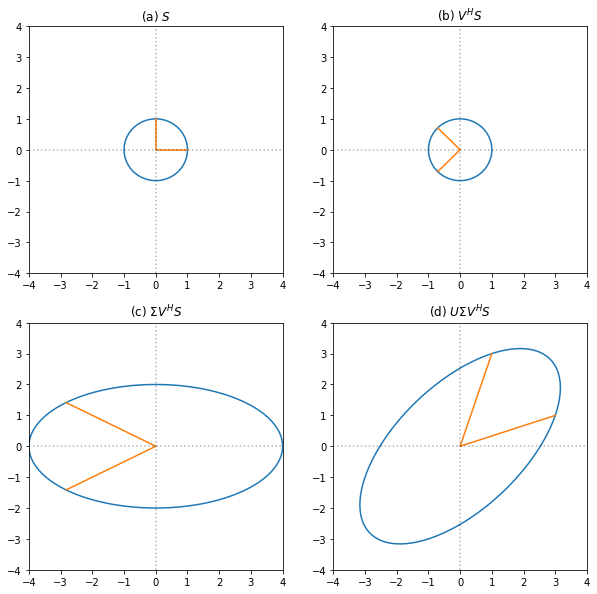

In [190]:
#Problem 2
def visualizeSVD(A):
    # A is an 2*2 matrix
    S=np.zeros((2,200))
    theta=np.linspace(0.0, 2*np.pi, 200)
    theta=np.sort(theta)
    S[0]=np.cos(theta)
    S[1]=np.sin(theta)
    E=np.array(([1,0,0],[0,0,1]))
    
    
    
    
    plt.figure(figsize = [10,10])
    
    axis = np.linspace(-4, 4, 10)
    
    U,sigma,Vh = la.svd(A, full_matrices=True)
    Sigma=np.diag(sigma)
    VhS = np.dot(Vh, S)
    VhE = np.dot(Vh, E)
    SigmaVhS = np.dot(Sigma, VhS)
    SigmaVhE = np.dot(Sigma, VhE)
    USigmaVhS = np.dot(U, SigmaVhS)
    USigmaVhE = np.dot(U, SigmaVhE)
    
    
    
    #plot 1
    plt.subplot(2,2,1)
    plt.plot(S[0], S[1])
    plt.plot(E[0], E[1])
    plt.plot(axis, np.zeros_like(axis), "k:", alpha = 0.3)
    plt.plot(np.zeros_like(axis), axis, "k:", alpha = 0.3)
    plt.xlim(-4,4)
    plt.ylim(-4,4)
    plt.title("(a) " + r"$S$")
    
    
    #plot 2
    plt.subplot(2,2,2)
    plt.plot(VhS[0], VhS[1])
    plt.plot(VhE[0], VhE[1])
    plt.plot(axis, np.zeros_like(axis), "k:", alpha = 0.3)
    plt.plot(np.zeros_like(axis), axis, "k:", alpha = 0.3)
    plt.xlim(-4,4)
    plt.ylim(-4,4)
    plt.title("(b) " + r"$V^H S$")
    
    #plot 3
    plt.subplot(2,2,3)
    plt.plot(SigmaVhS[0], SigmaVhS[1])
    plt.plot(SigmaVhE[0], SigmaVhE[1])
    plt.plot(axis, np.zeros_like(axis), "k:", alpha = 0.3)
    plt.plot(np.zeros_like(axis), axis, "k:", alpha = 0.3)
    plt.xlim(-4,4)
    plt.ylim(-4,4)
    plt.title("(c) " + r"$\Sigma V^H S$")
    
    #plot 4
    plt.subplot(2,2,4)
    plt.plot(USigmaVhS[0], USigmaVhS[1])
    plt.plot(USigmaVhE[0], USigmaVhE[1])
    plt.plot(axis, np.zeros_like(axis), "k:", alpha = 0.3)
    plt.plot(np.zeros_like(axis), axis, "k:", alpha = 0.3)
    plt.xlim(-4,4)
    plt.ylim(-4,4)
    plt.title("(d) " + r"$U \Sigma V^H S$")
    
    plt.show()
    
    
    
    
A = np.array([[3,1], [1,3]])
visualizeSVD(A)

In [191]:
#Problem 3
def lowRankApprox(A, s):
    U,sigma,Vh = la.svd(A, full_matrices=False)
    if s > np.linalg.matrix_rank(A): 
        raise ValueError('s should be less than rank')
    U = U[:,:s]
    sigma = sigma[:s]
    Vh=Vh[:s,:]
    return U, sigma, Vh, U.size+sigma.size+Vh.size

A=np.random.random((10,10))
lowRankApprox(A,6)

(array([[-0.34379991, -0.39428079,  0.2268852 ,  0.34368904,  0.10339053,
         -0.09548454],
        [-0.32206452,  0.16992354,  0.29669826, -0.54781273, -0.36054736,
         -0.15702442],
        [-0.316611  , -0.40828392,  0.10880418,  0.20721331,  0.1735322 ,
         -0.30169656],
        [-0.26779928,  0.22060102, -0.11353043,  0.59683705, -0.3099624 ,
          0.28288001],
        [-0.29474094,  0.37927301, -0.2584809 ,  0.11775553, -0.36724896,
         -0.47295737],
        [-0.33245165, -0.06916714, -0.52398518, -0.25604268,  0.42991608,
         -0.29543022],
        [-0.27335247,  0.16537166, -0.4637214 ,  0.00093152,  0.11206562,
          0.3535186 ],
        [-0.4196979 ,  0.07567765,  0.16751648, -0.23961138,  0.23547642,
          0.55977337],
        [-0.24979816, -0.52561845, -0.092103  , -0.18927764, -0.53176528,
          0.18018794],
        [-0.30895591,  0.37726161,  0.49275817,  0.09981243,  0.25028804,
         -0.11587539]]),
 array([4.83677756, 1.517554

In [192]:
#Problem 4
def SVDgivenEps(A, eps):
    
    U, sigma, Vh = la.svd(A, full_matrices=False)
    if eps < sigma.min(): 
        raise ValueError('invalid input')
    
    s = getRankNeeded(sigma, eps)
    print("We will use until the ", s+1, "th largest singular value")
    print("The curent singular value is ", sigma[s])
    print("The next singular value is ", sigma[s+1])


    U = U[:,:s+1]
    sigma = sigma[:s+1]
    Vh=Vh[:s+1,:]
    return U, sigma, Vh, U.size+sigma.size+Vh.size
    
    
            
def getRankNeeded(sigma, eps):
    # we assume at least need rank 1 approximation
    for i in range(1, len(sigma)):
        if sigma[i] < eps:
            return i - 1
    raise ValueError("epsilon is too small")
    
    
A = np.random.random((10,10))
U_s, sigma_s, Vh_s, size_s = SVDgivenEps(A, 0.3)
A_s = U_s@np.diag(sigma_s)@Vh_s
print("The approximation error is ", la.norm(A-A_s))
print("Note that the error is less than $\epsilon$")


        
    
    

We will use until the  8 th largest singular value
The curent singular value is  0.4871037497131121
The next singular value is  0.2330195154387937
The approximation error is  0.23772424045175566
Note that the error is less than $\epsilon$


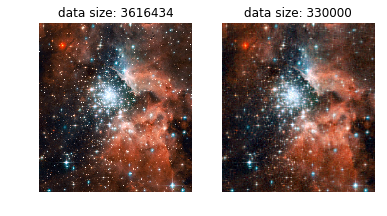

In [193]:
#Problem 5

def getResultAndDataSize(matrix, s):
    #print(np.linalg.matrix_rank(matrix))
    U_s, sigma_s, Vh_s, size_s = lowRankApprox(matrix, s)
    return U_s@np.diag(sigma_s)@Vh_s, size_s
    
def imageCompression(imageFile, s):
    imageMatrix = plt.imread(imageFile)/255
    
    #get original data size
    original_shape = imageMatrix.shape
    originalDataSize = 1
    for i in range(len(original_shape)):
        originalDataSize *= original_shape[i]
    
    if imageMatrix.ndim==3:
        #this is a color image
        R=imageMatrix[:,:,0]
        G=imageMatrix[:,:,1]
        B=imageMatrix[:,:,2]
        R_s, size_R = getResultAndDataSize(R, s)
        G_s, size_G = getResultAndDataSize(G, s)
        B_s, size_B = getResultAndDataSize(B, s)
        compressed = image=np.dstack((R_s,G_s,B_s))
        compressed = np.clip(compressed,0,1)
        newDataSize = size_R + size_G + size_B
        #display original image and new image
        plt.subplot(1,2,1)
        plt.imshow(imageMatrix)
        plt.axis("off")
        string = "data size: " + str(originalDataSize)
        plt.title(string)
        
        plt.subplot(1,2,2)
        plt.imshow(compressed)
        plt.axis("off")
        string = "data size: " + str(newDataSize)
        plt.title(string)
        plt.show()
        
    else:
        #this is a gray image
        compressed, newDataSize = getResultAndDataSize(imageMatrix, s)
        plt.subplot(2,1,1)
        plt.imshow(imageMatrix, cmap = "gray")
        plt.axis("off")
        
        plt.subplot(2,1,2)
        plt.imshow(compressed)
        plt.axis("off")
        plt.show()
        
imageCompression("hubble.jpg", 50)

Part 4 Drazin Inverse

In [194]:
#problem 1
def checkDrazin(A, k, A_D):
    if np.allclose(np.dot(A,A_D),np.dot(A_D, A)) == True:
        if np.allclose(np.dot(np.linalg.matrix_power(A,k+1),A_D), np.linalg.matrix_power(A,k)) == True:
            if np.allclose(np.dot(A_D,A,A_D),A_D) == True:
                return True
            else:
                return False
        else: 
            return False
    else: 
        return False
    
A = np.array([[1,3,0,0], [0,1,3,0], [0,0,1,3], [0,0,0,0]])
A_D = np.array([[1,-3,9,81],[0,1,-3,-18],[0,0,1,3],[0,0,0,0]])
checkDrazin(A, 1, A_D)

True

In [195]:
B = np.array(([1,1,3],[5,2,6],[-2,-1,-3]))
B_D = np.array(([0,0,0],[0,0,0],[0,0,0]))
checkDrazin(B,3,B_D)

True

In [196]:
# problem 2
def getDrazin(A, tol):
    m, n = A.shape
    
    f = lambda x: abs(x) > tol
    Q1,S,k1 = la.schur(A, sort=f)
    
    f = lambda x: abs(x) <= tol
    Q2,T,k2 = la.schur(A, sort=f)
    
    U=np.concatenate((S[:,:k1], T[:,:n-k1]), axis=1)

    V=np.linalg.inv(U)@A@U
    Z=np.zeros((n,n))
    if k1 != 0:
        M_1 = np.linalg.inv(V[:k1,:k1])
        Z[:k1,:k1]=M_1
    return U@Z@np.linalg.inv(U)

In [197]:
getDrazin(A,0.1)

array([[  1.,  -3.,   9.,  81.],
       [  0.,   1.,  -3., -18.],
       [  0.,   0.,   1.,   3.],
       [  0.,   0.,   0.,   0.]])

The Laplacian matrix is calculated by $L = D - A$, where $D$ is the degree matrix

In [198]:
#problem 3
def getResistance(A):
    m, n = A.shape
    degree = np.sum(A, axis = 0)
    D = np.diag(degree)
    L = D - A
    I = np.identity(n)
    R = np.zeros((n,n))
    for j in range(n):
        L1 = L.copy()
        L1[:, j] = I[:, j]
        L1_D = getDrazin(L1, 1e-8)
        R[:, j] = L1_D.diagonal()
        R[j, j] = 0
    return R

A=np.array([[0, 1, 0, 0], [1,  0,  1,  0], [0,  1,  0,  1], [0,  0,  1,  0]])
getResistance(A)


array([[0., 1., 2., 3.],
       [1., 0., 1., 2.],
       [2., 1., 0., 1.],
       [3., 2., 1., 0.]])

In [199]:
#Problem 4 and 5
class LinkPredictor:
    def __init__(self, filename):
        data = pd.read_csv(filename, header = None)
        
        #find all names
        temp = np.append(data[0], data[1])
        self.name_list = np.unique(temp)
        self.n=len(self.name_list)
        ajmat = np.zeros((self.n,self.n))
        for i in data.index:
            name1, name2 = data.iloc[i][0], data.iloc[i][1]
            #find corresponding index in name_list
            name1Index = np.where(name1 == self.name_list)
            name2Index = np.where(name2 == self.name_list)
            ajmat[name1Index, name2Index] = 1
            ajmat[name2Index, name1Index] = 1
        self.adjacency = ajmat
        self.resistance = getResistance(ajmat)
        
    def predict_link(self, node):
        unconnected_res = self.resistance*(1-self.adjacency)
        if node == None:
            
            minRes = np.min(unconnected_res[np.nonzero(unconnected_res)])
            pos = np.where(unconnected_res==minRes)
            #print(pos)
            return self.name_list[pos[0]], self.name_list[pos[1]]
            
        elif (node in self.name_list):
            pos = np.where(self.name_list == node)
            this_person = unconnected_res[:, pos]
            
            localMin = np.min(this_person[this_person>0])
            the_other_half = np.where(this_person == localMin)
           
           
            return self.name_list[the_other_half[0]]
        else:
            raise ValueError("Node not found")
            
    def add_link(self, node1, node2):
        if (not node1 in self.name_list) or (not node2 in self.name_list):
            raise ValueError("Node not in list")
        else:
            pos1 = np.where(self.name_list==node1)
            pos2 = np.where(self.name_list==node2)
            self.adjacency[pos1, pos2] = 1
            self.adjacency[pos2, pos1] = 1
            self.resistance = getResistance(self.adjacency)
            
            
            
        

In [200]:
lp = LinkPredictor("social_network.csv")

lp.predict_link('Melanie')

array(['Carol'], dtype=object)

In [201]:
lp.predict_link(None)


(array(['Emily'], dtype=object), array(['Oliver'], dtype=object))

In [202]:
lp.add_link("Emily", "Oliver")

Part 5 PageRank

In [203]:
#Problem 1
def createAdjMat(fileName):
    nodes = []
    nodeset = set()
    with open(fileName, 'r') as myfile:
         for line in myfile:
            try:
                line = list(map(int, line.strip().split()))
                nodes.append(line)
                nodeset.add(line[0])
                nodeset.add(line[1])
            except:
                pass
    N = len(nodeset)
    adjmat = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            if [i,j] in nodes:
                adjmat[i,j]=1
                
    return adjmat

website = createAdjMat("matrix.txt")

In [204]:
#Problem 2
def computeK(A):
    #modify A
    isSink = (A.sum(axis = 1) == 0)
    A[isSink, :] = np.ones(len(A))
    
    d_diag = A.sum(axis = 1)
    D = np.diag(d_diag)
    
    K = (np.linalg.inv(D) @ A).T
    
    return K
    
computeK(website)
    

array([[0.        , 1.        , 0.125     , 0.33333333, 0.33333333,
        0.5       , 1.        , 1.        ],
       [0.        , 0.        , 0.125     , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.125     , 0.33333333, 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.125     , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.125     , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.125     , 0.        , 0.33333333,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.125     , 0.33333333, 0.33333333,
        0.5       , 0.        , 0.        ],
       [1.        , 0.        , 0.125     , 0.        , 0.        ,
        0.        , 0.        , 0.        ]])

We want to solve the steady state for the dynamic system 
$$\vec{p}(t+1) = d K \vec{p}(t) + \frac{1-d}{N}\vec{1}$$


In [205]:
#Problem 3
def iterativeLimit(A, N=None, d=0.85, tol = 1e-9):
    if N!= None:
        A = A[0:N, 0:N]
    K = computeK(A)
    
    m, n = A.shape
    #get a random unit guess
    p_0 = np.random.rand(n)
    p_0 = p_0 / np.sum(p_0)
    
    maxItr = 10000
    currentItr = 0
    
    difference = 1
    
    while (currentItr < maxItr) or (difference > tol):
        p_1 = d * (K @ p_0) + (1-d)/n * np.ones(n)
        difference = la.norm(p_1 - p_0)
        currentItr += 1
        p_0 = p_1
    return p_0
    

In [206]:
steady_p = iterativeLimit(website)
#test if it is the steady state
print(steady_p)
0.85 * (computeK(website) @ steady_p) + (1-0.85)/len(steady_p) * np.ones(len(steady_p))

[0.43869288 0.02171029 0.02786154 0.02171029 0.02171029 0.02786154
 0.04585394 0.39459924]


array([0.43869288, 0.02171029, 0.02786154, 0.02171029, 0.02171029,
       0.02786154, 0.04585394, 0.39459924])

We want to solve the steady state for the dynamic system 
$$\vec{p}(t+1) = (d K  + \frac{1-d}{N}E)\vec{p}(t)$$

In [207]:
#problem 4
def eigSteadyState(A, N = None, d=0.85):
    if N!= None:
        A = A[0:N, 0:N]
    K = computeK(A)
    B = d * K + (1-d)/len(A)
    eigval, eigvec = la.eig(B)
    p_0 = eigvec[:,0] / eigvec[:,0].sum()
    return p_0
eigSteadyState(website)

array([0.43869288-0.j, 0.02171029-0.j, 0.02786154-0.j, 0.02171029-0.j,
       0.02171029-0.j, 0.02786154-0.j, 0.04585394-0.j, 0.39459924-0.j])

In [208]:
# problem 5
def teamRank():
    with open('ncaa2013.csv','r') as f:
        #skip the header
        f.readline()
        #create list to hold team names
        winners = []
        losers = []
        teams = []
        for line in f:
            temp = line.strip().split(',')
            winners.append(temp[0])
            losers.append(temp[1])
            if not (temp[0] in teams):
                teams.append(temp[0])
            if not (temp[1] in teams):
                teams.append(temp[1])
     
    winners = np.array(winners)
    losers = np.array(losers)
    teams = np.array(teams)
    #teams functions as a table to link index with team names
    #total number of teams
    n = len(teams)
    print(n)
    adja = np.zeros((n,n))
    
    for j in range(len(winners)):
        winIndex = np.where(teams == winners[j])
        loseIndex = np.where(teams == losers[j])
        #edge points from lose to win
        adja[loseIndex, winIndex] = 1
    
    winning = iterativeLimit(adja, d = 0.7)
    #sort in descending order
    rank = (np.argsort(winning))
    #print(rank)
    print(teams[rank[-1:-6:-1]])
    print(winning[rank[-1:-6:-1]])
    return winning, teams[rank]
  


In [209]:
x, y =teamRank()



347
['Duke' 'Butler' 'Louisville' 'Illinois' 'Indiana']
[0.00965674 0.0085354  0.00849496 0.00833203 0.00822151]


Part 6 Conditioning and Stability

In [214]:
#problem 1
def calculate_condition_number(A):
    U, Sigma, VT = la.svd(A)
    max_s = Sigma[0]
    min_s = Sigma[-1]
    if min_s == 0:
        return np.inf
    return max_s / float(min_s)

test_mat = np.array([[1,3],[8,2]])
print("test a random matrix")
print(calculate_condition_number(test_mat))
print(np.linalg.cond(test_mat))
print("test a singular matrix")
sin_mat = np.ones((2,2))
print(calculate_condition_number(sin_mat))
print("test an orthonormal matrix")
Q, R = la.qr(test_mat)
print(calculate_condition_number(Q))

test a random matrix
3.236476562554965
3.236476562554965
test a singular matrix
inf
test an orthonormal matrix
1.0


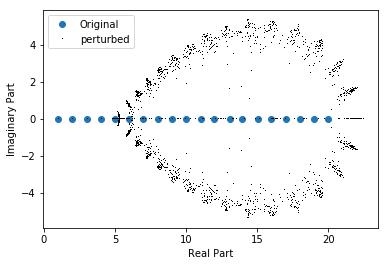

 absolute condition number is 3.51145979192290e-9
 relative condition number is 2423585093.15704


In [215]:
#problem 2
import sympy as sy

def random_perturbation():
    x, i = sy.symbols('x i')
    w = sy.poly_from_expr(sy.product(x-i, (i, 1, 20)))[0]
    w_coeffs = np.array(w.all_coeffs())
    roots = np.roots(np.poly1d(w_coeffs))
    plt.plot(roots, np.zeros(20), 'o', label = "Original")
    list1 = []
    list2 = []
    for i in range (0,100):
        c = np.random.normal(1, 1e-10, 21)
        newcoeffs = w_coeffs * c
        newroots = np.roots(np.poly1d(newcoeffs))
        if i == 99:
            plt.plot(newroots.real, newroots.imag, 'k,', label = "perturbed") 
            plt.xlabel("Real Part")
            plt.ylabel("Imaginary Part")
            plt.legend()
        else:
            plt.plot(newroots.real, newroots.imag, 'k,') 
        h = newcoeffs - w_coeffs
        acn = la.norm(newroots - roots, np.inf) / la.norm(h, np.inf)
        rcn = acn * la.norm(w_coeffs, np.inf) / la.norm(roots, np.inf) 
        list1 = list1 + [acn]
        list2 = list2 + [rcn]
    plt.show()
    print(" absolute condition number is", np.mean(list1))
    print(" relative condition number is", np.mean(list2))

random_perturbation()

In [219]:
#Problem 3
def eig_condition(A):
    
    n=len(A)
    real = np.random.normal(0, 1e-10, (n,n))
    imag = np.random.normal(0, 1e-10, (n,n))
    H = real + 1j*imag
    eigenvalues_A = la.eigvals(A)
    eigenvalues_AH = la.eigvals(A+H)
    #diff = A_val - eig_val
    acn = (la.norm(eigenvalues_A - eigenvalues_AH, 2)) / (la.norm(H, 2))
    rcn = acn * (la.norm(A, 2)) / (la.norm(eigenvalues_A, 2))
    return acn, rcn
eig_condition(np.random.rand(4, 4))


(1527574185.4373999, 1458675212.739712)

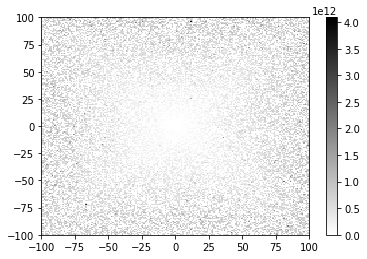

In [223]:
# problem 4
def plot_condition_numbers(bounds, res=200):  
    x_min, x_max, y_min, y_max = bounds
    x = np.linspace(x_min, x_max, res)
    y = np.linspace(y_min, y_max, res)
    condition = np.zeros((res, res))
    for i in range(res):
        for j in range(res):
            A = np.array([[1, x[i]], [y[j], 1]])
            condition[i,j] = eig_condition(A)[1]
    plt.pcolormesh(x, y, condition, cmap='gray_r')
    plt.colorbar()
    plt.show()
plot_condition_numbers([-100,100,-100,100])

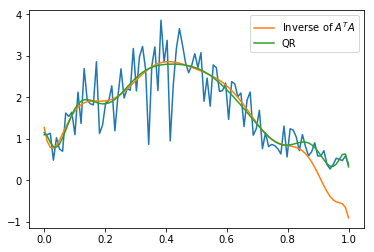

In [230]:
# problem 5 
def condition_OLS(n):
    xk, yk = np.load('stability_data.npy').T
    A = np.vander(xk, n + 1)
    
    c_1 = la.inv(A.T @ A) @ A.T @ yk
    error_1 = np.linalg.norm(A @ c_1 - yk)
    
    Q , R = la.qr(A, mode='economic')
    c_2 = la.solve_triangular(R, Q.T @ yk)
    error_2 = np.linalg.norm(A @ c_2 - yk)
    
    plt.plot(xk, yk)
    
    plt.plot(xk, np.polyval(c_1, xk), label= r"Inverse of $A^{T}A$")
    plt.plot(xk, np.polyval(c_2, xk), label = "QR")
    plt.legend()
    
condition_OLS(14)

true results:  [0.14553294057307858, 0.08387707010339417, 0.059017540879297774, 0.045544884075818054, 0.03708621442373924, 0.03127967393216808, 0.027046289409060773, 0.02382272866903348, 0.021286039085606067, 0.019237754434339383]
estimated results:  [0.145532940573077, 0.0838770701084286, 0.0590209960937500, -128.000000000000, 0, 0, 0, 0, 0, 0]


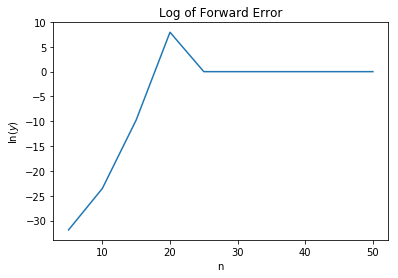

In [259]:
#problem 6
def catastrophic_cancellation():
    
    n_grid = np.arange(5, 55, 5)
    x = sy.Symbol('x')
    true_values = []
    est_values = []
    for n in n_grid:
        true_values.append(float(sy.integrate(x**n * sy.exp(x - 1), (x, 0, 1))))
        est_values.append((-1)**n * sy.subfactorial(n) + (-1)**(n+1) * sy.factorial(n) / math.e)
    print("true results: ", true_values)
    print("estimated results: ", est_values)
    
    errors = []
    for i in range(len(true_values)):
        errors.append(float(abs(est_values[i] - true_values[i]) / abs(true_values[i])))
    
    errors = np.array(errors)
    
    plt.plot(n_grid, np.log(errors))
    plt.title("Log of Forward Error")
    plt.xlabel("n")
    plt.ylabel(r"$\ln(y)$")
    
catastrophic_cancellation()

    

It is not a stable way to calculate the integral. This is because $(-1)^n !n$ and $(-1)^{n+1}\frac{n!}{e}$ have almost the same magnitude but opposite sign. The subtration will result in cancellation error.